In [1]:
!pip install ax-platform textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.6/280.6 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 786.8/786.8 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import re
import string
from textblob import Word

import itertools
from collections import defaultdict

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from ax.api.client import Client
from ax.api.configs import ChoiceParameterConfig, RangeParameterConfig

[WARNING 12-14 23:18:28] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
data = pd.read_csv('/content/drive/MyDrive/Colab Data/CSC705_Project/AVC_claims_survey.sql.csv', dtype={'comments': str})

In [6]:
# Randomly reorder the DataFrame
data = data.sample(frac=1).reset_index(drop=True)
satisfied = data['satisfied']


# Convert the pandas Series y to a torch LongTensor
y_tensor = torch.tensor(satisfied.values, dtype=torch.long)

# Perform one-hot encoding. Since labels are 1-5, we need 6 classes (0-5) to accommodate.
# Then, we'll remove the first column (index 0) which corresponds to a non-existent class.
satisfied_oh = F.one_hot(y_tensor, num_classes=6)[:, 1:]

In [7]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [8]:
data['comments'] = data['comments'].astype(str).fillna('')
# Split on any character that is NOT a word character (alphanumeric) or is an underscore.
# This effectively isolates all punctuation and symbols.
pattern = r'(\W|_)'
comments = [re.split(pattern, text.lower()) for text in data['comments']]
comments = [
    [item.strip() for item in sublist if item.strip()]
    for sublist in comments
]
comments = [
    [Word(item).lemmatize() for item in sublist]
    for sublist in comments
]

In [9]:
# Display unique tokens to verify separation
all_words = sorted(set(list(itertools.chain.from_iterable(comments))))

In [10]:
vocab = {i:t for i, t in enumerate(all_words)}
lookup = {token:integer for integer,token in vocab.items()}

In [11]:
encoded = [
    [lookup[token] for token in comment]
    for comment in comments
]
print([e[:5] for e in encoded])

[[5553, 10267, 8720, 9382, 5852], [11861, 2723, 3530, 800, 5012], [7327, 3329, 11444, 3, 513], [7327, 2522, 11444, 917, 5201], [7327, 2522, 8953, 11, 7290], [10645, 4117, 8342, 10812, 10811], [6220, 9158, 11444, 10596, 0], [2371, 10645, 1808, 4331, 11], [10628, 11856, 4668, 6801, 10691], [5553, 5279, 5161, 11003, 2522], [11450, 62, 7245, 4668, 7953], [4580, 10754, 917, 5885, 11691], [9382, 5852, 11444, 3975, 11], [5997, 11444, 9979, 3549, 10785], [7798, 10645, 2522, 4331, 11444], [7327, 2522, 11444, 8765, 4668], [7327, 8953, 9585, 7796, 2149], [5553, 5279, 7545, 1743, 5960], [5553, 5279, 10199, 10785, 8685], [5553, 6, 6742, 4381, 5227], [5079, 9648], [4216, 5553, 3268, 11691, 11444], [5079, 9648, 1205, 10703, 13], [7327, 1563, 948, 6601, 11444], [9636, 793, 793, 793, 793], [8898, 3187, 9648, 11, 10393], [3274, 9382, 11, 10628, 11856], [3187, 9648, 11444, 4562, 11], [7327, 2522, 947, 6021, 9919], [11614, 10645, 3209, 10639, 6460], [11528, 11572, 11358, 5227, 11691], [6908, 4020, 11, 375

In [12]:
encoded = [torch.LongTensor(e) for e in encoded]

In [13]:
padded = pad_sequence(encoded, batch_first=True, padding_value=0).long()

In [14]:
from sklearn.model_selection import train_test_split

# Split the encoded comments and satisfied_oh labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    encoded, satisfied_oh, test_size=0.2, random_state=42
)

print(f"Training comments size: {len(X_train)}")
print(f"Testing comments size: {len(X_test)}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training comments size: 8559
Testing comments size: 2140
Training labels shape: torch.Size([8559, 5])
Testing labels shape: torch.Size([2140, 5])


In [15]:
import numpy as np

comment_lengths = [len(comment) for comment in comments]

mean_length = np.mean(comment_lengths)
median_length = np.median(comment_lengths)

print(f"Mean comment length: {mean_length:.2f} words")
print(f"Median comment length: {median_length:.2f} words")

Mean comment length: 53.84 words
Median comment length: 37.00 words


In [16]:
class GRU_nn(nn.Module):
    def __init__(self, vocabulary_size, embedding_dim, hidden_size, num_layers, output_size):
        super(GRU_nn, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Embedding layer
        self.embedding = nn.Embedding(vocabulary_size, embedding_dim)

        # GRU layer, input_size is now embedding_dim
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True)

        # Fully connected layer to get the final output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x)

        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate the GRU
        out, _ = self.gru(x, h0)  # out: batch_size, seq_len, hidden_size

        # Take the output from the last time step
        out = out[:, -1, :]

        # Pass through the fully connected layer
        out = self.fc(out)
        # Apply sigmoid to output for BCELoss, as it expects probabilities
        out = torch.sigmoid(out)
        return out

In [17]:
class TextDataset(Dataset):
    def __init__(self, encoded_texts, labels):
        self.encodings = [torch.tensor(seq, dtype=torch.long) for seq in encoded_texts]
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.encodings[idx], self.labels[idx]

In [18]:
def collate_batch(batch):
    texts, labels = zip(*batch)
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=0)
    return padded_texts, torch.stack(labels)

In [19]:
#Ax configuration
client = Client()
parameters = [
    RangeParameterConfig(
        name="hidden_size", parameter_type="int", bounds=(5, 20)
    ),
    RangeParameterConfig(
        name="num_layers", parameter_type="int", bounds=(1, 5)
    ),
    ChoiceParameterConfig(
        name="learning_rate",
        parameter_type="float",
        values=(0.0001, 0.001, 0.01),
        is_ordered=True
    ),
]

client.configure_experiment(parameters=parameters)

metric_name = "loss"
client.configure_optimization(objective=f"-{metric_name}")

In [20]:
embedding_dim = 100
hidden_size = 20
num_layers = 1
output_size = 5
vocabulary_size = len(vocab)
learning_rate = 0.01

losses = defaultdict(list)

for i in range(10):
    trials = client.get_next_trials(max_trials=3)

    for trial_index, parameters in trials.items():
        hidden_size = parameters["hidden_size"]
        num_layers = parameters["num_layers"]
        learning_rate = parameters["learning_rate"]

        print("Hyperparameters: ", hidden_size, num_layers, learning_rate)

        dataset = TextDataset(X_train, y_train)
        dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_batch)

        model = GRU_nn(len(vocab), embedding_dim, hidden_size, num_layers, output_size).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        num_epochs = 3

        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            for batch_idx, (X, y) in enumerate(dataloader):
                X = X.to(device)
                y = y.to(device)
                optimizer.zero_grad()
                outputs = model(X)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            losses[(i, trial_index, hidden_size, num_layers, learning_rate)].append(total_loss)

            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')

        print("Training completed.")

        # Set raw_data as a dictionary with metric names as keys and results as values
        raw_data = {metric_name: total_loss}

        # Complete the trial with the result
        client.complete_trial(trial_index=trial_index, raw_data=raw_data)

[INFO 12-14 23:19:03] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 12-14 23:19:03] ax.api.client: Generated new trial 0 with parameters {'hidden_size': 12, 'num_layers': 3, 'learning_rate': 0.001} using GenerationNode CenterOfSearchSpace.
[INFO 12-14 23:19:03] ax.api.client: Generated new trial 1 with parameters {'hidden_size': 17, 'num_layers': 4, 'learning_rate': 0.01} using GenerationNode Sobol.
[INFO 12-14 23:19:03] ax.api.client: Generated new trial 2 with parameters {'hidden_size': 8, 'num_layers': 2, 'learning_rate': 0.0001} usi

Hyperparameters:  12 3 0.001
Epoch [1/3], Loss: 1468.4181
Epoch [2/3], Loss: 1211.4607


[INFO 12-14 23:19:45] ax.api.client: Trial 0 marked COMPLETED.


Epoch [3/3], Loss: 1111.0673
Training completed.
Hyperparameters:  17 4 0.01


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1422.4355
Epoch [2/3], Loss: 1357.6745


[INFO 12-14 23:20:28] ax.api.client: Trial 1 marked COMPLETED.


Epoch [3/3], Loss: 1374.0633
Training completed.
Hyperparameters:  8 2 0.0001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1915.1924
Epoch [2/3], Loss: 1608.9634


[INFO 12-14 23:21:02] ax.api.client: Trial 2 marked COMPLETED.
[INFO 12-14 23:21:02] ax.api.client: Generated new trial 3 with parameters {'hidden_size': 9, 'num_layers': 4, 'learning_rate': 0.01} using GenerationNode Sobol.
[INFO 12-14 23:21:02] ax.api.client: Generated new trial 4 with parameters {'hidden_size': 16, 'num_layers': 2, 'learning_rate': 0.0001} using GenerationNode Sobol.
[WARNING 12-14 23:21:02] ax.api.client: 3 trials requested but only 2 could be generated.


Epoch [3/3], Loss: 1577.3714
Training completed.
Hyperparameters:  9 4 0.01


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1424.5149
Epoch [2/3], Loss: 1315.5657


[INFO 12-14 23:21:45] ax.api.client: Trial 3 marked COMPLETED.


Epoch [3/3], Loss: 1298.7798
Training completed.
Hyperparameters:  16 2 0.0001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1801.0106
Epoch [2/3], Loss: 1587.1912


[INFO 12-14 23:22:19] ax.api.client: Trial 4 marked COMPLETED.


Epoch [3/3], Loss: 1546.9324
Training completed.


[INFO 12-14 23:22:19] ax.api.client: Generated new trial 5 with parameters {'hidden_size': 5, 'num_layers': 4, 'learning_rate': 0.001} using GenerationNode MBM.
[WARNING 12-14 23:22:19] ax.api.client: 3 trials requested but only 1 could be generated.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  5 4 0.001
Epoch [1/3], Loss: 1563.5792
Epoch [2/3], Loss: 1307.1995


[INFO 12-14 23:23:02] ax.api.client: Trial 5 marked COMPLETED.


Epoch [3/3], Loss: 1226.8020
Training completed.


[INFO 12-14 23:23:02] ax.api.client: Generated new trial 6 with parameters {'hidden_size': 20, 'num_layers': 2, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-14 23:23:02] ax.api.client: Generated new trial 7 with parameters {'hidden_size': 5, 'num_layers': 2, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-14 23:23:02] ax.api.client: Generated new trial 8 with parameters {'hidden_size': 20, 'num_layers': 3, 'learning_rate': 0.001} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  20 2 0.001
Epoch [1/3], Loss: 1426.3603
Epoch [2/3], Loss: 1188.5425


[INFO 12-14 23:23:36] ax.api.client: Trial 6 marked COMPLETED.


Epoch [3/3], Loss: 1088.0937
Training completed.
Hyperparameters:  5 2 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1617.9655
Epoch [2/3], Loss: 1348.7897


[INFO 12-14 23:24:10] ax.api.client: Trial 7 marked COMPLETED.


Epoch [3/3], Loss: 1216.2765
Training completed.
Hyperparameters:  20 3 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1436.2669
Epoch [2/3], Loss: 1200.2342


[INFO 12-14 23:24:48] ax.api.client: Trial 8 marked COMPLETED.


Epoch [3/3], Loss: 1084.8048
Training completed.


[INFO 12-14 23:24:48] ax.api.client: Generated new trial 9 with parameters {'hidden_size': 18, 'num_layers': 5, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-14 23:24:48] ax.api.client: Generated new trial 10 with parameters {'hidden_size': 18, 'num_layers': 1, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-14 23:24:48] ax.api.client: Generated new trial 11 with parameters {'hidden_size': 20, 'num_layers': 5, 'learning_rate': 0.001} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  18 5 0.001
Epoch [1/3], Loss: 1488.9241
Epoch [2/3], Loss: 1223.8600


[INFO 12-14 23:25:36] ax.api.client: Trial 9 marked COMPLETED.


Epoch [3/3], Loss: 1111.0311
Training completed.
Hyperparameters:  18 1 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1487.0585
Epoch [2/3], Loss: 1217.5815


[INFO 12-14 23:26:05] ax.api.client: Trial 10 marked COMPLETED.


Epoch [3/3], Loss: 1113.1261
Training completed.
Hyperparameters:  20 5 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1465.6842
Epoch [2/3], Loss: 1215.3619


[INFO 12-14 23:26:52] ax.api.client: Trial 11 marked COMPLETED.


Epoch [3/3], Loss: 1113.9069
Training completed.


[INFO 12-14 23:26:52] ax.api.client: Generated new trial 12 with parameters {'hidden_size': 18, 'num_layers': 3, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-14 23:26:52] ax.api.client: Generated new trial 13 with parameters {'hidden_size': 5, 'num_layers': 1, 'learning_rate': 0.01} using GenerationNode MBM.
[INFO 12-14 23:26:52] ax.api.client: Generated new trial 14 with parameters {'hidden_size': 17, 'num_layers': 3, 'learning_rate': 0.001} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  18 3 0.001


/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1450.0740
Epoch [2/3], Loss: 1206.0249


[INFO 12-14 23:27:31] ax.api.client: Trial 12 marked COMPLETED.


Epoch [3/3], Loss: 1099.3572
Training completed.
Hyperparameters:  5 1 0.01


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1574.5617
Epoch [2/3], Loss: 1479.3723


[INFO 12-14 23:28:00] ax.api.client: Trial 13 marked COMPLETED.


Epoch [3/3], Loss: 1442.1942
Training completed.
Hyperparameters:  17 3 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1465.3639
Epoch [2/3], Loss: 1208.9560


[INFO 12-14 23:28:39] ax.api.client: Trial 14 marked COMPLETED.


Epoch [3/3], Loss: 1102.7505
Training completed.


[INFO 12-14 23:28:39] ax.api.client: Generated new trial 15 with parameters {'hidden_size': 19, 'num_layers': 3, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-14 23:28:39] ax.api.client: Generated new trial 16 with parameters {'hidden_size': 18, 'num_layers': 2, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-14 23:28:39] ax.api.client: Generated new trial 17 with parameters {'hidden_size': 15, 'num_layers': 1, 'learning_rate': 0.001} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  19 3 0.001
Epoch [1/3], Loss: 1438.7874
Epoch [2/3], Loss: 1198.9728


[INFO 12-14 23:29:18] ax.api.client: Trial 15 marked COMPLETED.


Epoch [3/3], Loss: 1086.6957
Training completed.
Hyperparameters:  18 2 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1456.5519
Epoch [2/3], Loss: 1196.3281


[INFO 12-14 23:29:52] ax.api.client: Trial 16 marked COMPLETED.


Epoch [3/3], Loss: 1092.9717
Training completed.
Hyperparameters:  15 1 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1546.2807
Epoch [2/3], Loss: 1250.9945


[INFO 12-14 23:30:21] ax.api.client: Trial 17 marked COMPLETED.


Epoch [3/3], Loss: 1144.0428
Training completed.


[INFO 12-14 23:30:21] ax.api.client: Generated new trial 18 with parameters {'hidden_size': 20, 'num_layers': 4, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-14 23:30:21] ax.api.client: Generated new trial 19 with parameters {'hidden_size': 18, 'num_layers': 4, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-14 23:30:21] ax.api.client: Generated new trial 20 with parameters {'hidden_size': 17, 'num_layers': 4, 'learning_rate': 0.001} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  20 4 0.001
Epoch [1/3], Loss: 1411.1894
Epoch [2/3], Loss: 1187.8560


[INFO 12-14 23:31:04] ax.api.client: Trial 18 marked COMPLETED.


Epoch [3/3], Loss: 1078.8074
Training completed.
Hyperparameters:  18 4 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1427.2179
Epoch [2/3], Loss: 1203.8885


[INFO 12-14 23:31:47] ax.api.client: Trial 19 marked COMPLETED.


Epoch [3/3], Loss: 1089.6582
Training completed.
Hyperparameters:  17 4 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1429.3601
Epoch [2/3], Loss: 1185.0469


[INFO 12-14 23:32:30] ax.api.client: Trial 20 marked COMPLETED.


Epoch [3/3], Loss: 1075.1892
Training completed.


[INFO 12-14 23:32:30] ax.api.client: Generated new trial 21 with parameters {'hidden_size': 19, 'num_layers': 4, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-14 23:32:30] ax.api.client: Generated new trial 22 with parameters {'hidden_size': 16, 'num_layers': 4, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-14 23:32:30] ax.api.client: Generated new trial 23 with parameters {'hidden_size': 20, 'num_layers': 1, 'learning_rate': 0.001} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  19 4 0.001
Epoch [1/3], Loss: 1458.8739
Epoch [2/3], Loss: 1198.5620


[INFO 12-14 23:33:13] ax.api.client: Trial 21 marked COMPLETED.


Epoch [3/3], Loss: 1087.2306
Training completed.
Hyperparameters:  16 4 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1487.2161
Epoch [2/3], Loss: 1230.5043


[INFO 12-14 23:33:56] ax.api.client: Trial 22 marked COMPLETED.


Epoch [3/3], Loss: 1132.4957
Training completed.
Hyperparameters:  20 1 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1482.8734
Epoch [2/3], Loss: 1214.9620


[INFO 12-14 23:34:25] ax.api.client: Trial 23 marked COMPLETED.


Epoch [3/3], Loss: 1106.6750
Training completed.


[INFO 12-14 23:34:25] ax.api.client: Generated new trial 24 with parameters {'hidden_size': 19, 'num_layers': 5, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-14 23:34:25] ax.api.client: Generated new trial 25 with parameters {'hidden_size': 19, 'num_layers': 2, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-14 23:34:25] ax.api.client: Generated new trial 26 with parameters {'hidden_size': 16, 'num_layers': 3, 'learning_rate': 0.001} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  19 5 0.001
Epoch [1/3], Loss: 1421.4285
Epoch [2/3], Loss: 1200.1821


[INFO 12-14 23:35:13] ax.api.client: Trial 24 marked COMPLETED.


Epoch [3/3], Loss: 1097.5847
Training completed.
Hyperparameters:  19 2 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1431.2483
Epoch [2/3], Loss: 1184.6761


[INFO 12-14 23:35:47] ax.api.client: Trial 25 marked COMPLETED.


Epoch [3/3], Loss: 1073.6399
Training completed.
Hyperparameters:  16 3 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1445.5070
Epoch [2/3], Loss: 1200.9044


[INFO 12-14 23:36:25] ax.api.client: Trial 26 marked COMPLETED.


Epoch [3/3], Loss: 1097.2537
Training completed.


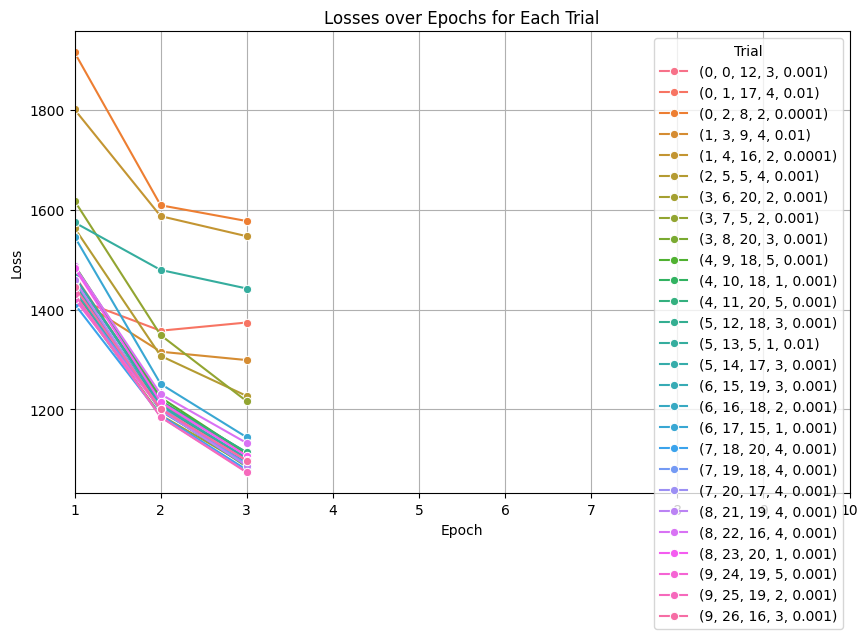

In [21]:
# Prepare data for plotting
plot_data = []
for trial_idx, trial_losses in losses.items():
    for epoch, loss_val in enumerate(trial_losses):
        plot_data.append({'Trial': trial_idx, 'Epoch': epoch + 1, 'Loss': loss_val})

df_losses = pd.DataFrame(plot_data)

# Plotting the losses
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_losses, x='Epoch', y='Loss', hue='Trial', marker='o')
plt.title('Losses over Epochs for Each Trial')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xlim(1, 10) # Set x-axis limit to 10 epochs
plt.show()

In [22]:
lowest_loss = float('inf')
best_hyperparameters = None

for (iteration, trial_index, hidden_size, num_layers, learning_rate), trial_losses in losses.items():
    final_loss = trial_losses[-1]  # Get the last recorded loss for the trial
    if final_loss < lowest_loss:
        lowest_loss = final_loss
        best_hyperparameters = {
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'learning_rate': learning_rate
        }

print(f"Lowest final loss: {lowest_loss:.4f}")
print(f"Best hyperparameters: {best_hyperparameters}")

Lowest final loss: 1073.6399
Best hyperparameters: {'hidden_size': 19, 'num_layers': 2, 'learning_rate': 0.001}


In [23]:
hidden_size = best_hyperparameters["hidden_size"]
num_layers = best_hyperparameters["num_layers"]
learning_rate = best_hyperparameters["learning_rate"]
num_epochs = 10

def create_model(epochs, hidden_size, num_layers, learning_rate, X_train, y_train):
    print("Hyperparameters: ", hidden_size, num_layers, learning_rate)

    dataset = TextDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_batch)

    model = GRU_nn(len(vocab), embedding_dim, hidden_size, num_layers, output_size).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_idx, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')

    print("Training completed.")
    return model, total_loss


In [24]:
model, loss = create_model(num_epochs, hidden_size, num_layers, learning_rate, X_train, y_train)

Hyperparameters:  19 2 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/10], Loss: 1408.9544
Epoch [2/10], Loss: 1179.0797
Epoch [3/10], Loss: 1071.8636
Epoch [4/10], Loss: 964.8414
Epoch [5/10], Loss: 863.3697
Epoch [6/10], Loss: 782.0440
Epoch [7/10], Loss: 705.5324
Epoch [8/10], Loss: 637.7032
Epoch [9/10], Loss: 574.6598
Epoch [10/10], Loss: 530.3413
Training completed.


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error

# Create test dataset and dataloader
test_dataset = TextDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_batch)

# Set model to evaluation mode
model.eval()

all_predictions = []
all_true_labels = []

with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)

        outputs = model(X)

        # Convert outputs from probabilities (5 columns) to predicted class indices (0-4 for 1-5 satisfaction)
        # Since outputs are sigmoid, they are probabilities for each class. For multi-class, we take the argmax.
        predicted_labels = torch.argmax(outputs, dim=1)

        # Convert one-hot encoded true labels to class indices (0-4 for 1-5 satisfaction)
        true_labels = torch.argmax(y, dim=1)

        all_predictions.extend(predicted_labels.cpu().numpy())
        all_true_labels.extend(true_labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_true_labels, all_predictions)
precision = precision_score(all_true_labels, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_true_labels, all_predictions, average='weighted', zero_division=0)
f1 = f1_score(all_true_labels, all_predictions, average='weighted', zero_division=0)
mae = mean_absolute_error(all_true_labels, all_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MAE: {mae:.4f}")

/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Accuracy: 0.6103
Precision: 0.6229
Recall: 0.6103
F1 Score: 0.6140
MAE: 0.5682


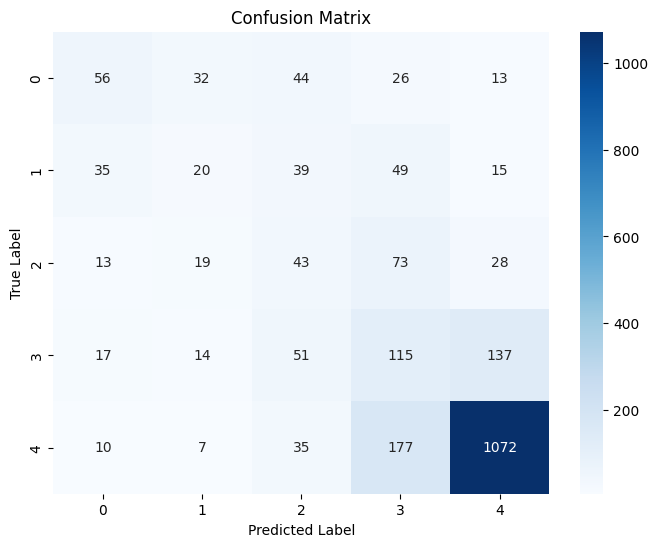

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [28]:
# Convert one-hot encoded y_train and y_test back to original integer labels (1-5)
y_train_original_labels = torch.argmax(y_train, dim=1) + 1
y_test_original_labels = torch.argmax(y_test, dim=1) + 1

# Define the mapping function for 3 categories
def map_to_3_categories(label):
    if label <= 2:  # 1 or 2 -> Negative (map to 0)
        return 0
    elif label == 3:  # 3 -> Neutral (map to 1)
        return 1
    else:  # 4 or 5 -> Positive (map to 2)
        return 2

# Apply the mapping to create new labels
y_train_3_categories = torch.tensor([map_to_3_categories(l.item()) for l in y_train_original_labels], dtype=torch.long)
y_test_3_categories = torch.tensor([map_to_3_categories(l.item()) for l in y_test_original_labels], dtype=torch.long)

# One-hot encode the new 3-category labels
# num_classes for one-hot encoding should be 3 for 0, 1, 2 categories
y_train_3_categories_oh = F.one_hot(y_train_3_categories, num_classes=3).float()
y_test_3_categories_oh = F.one_hot(y_test_3_categories, num_classes=3).float()

print(f"New y_train shape (3 categories): {y_train_3_categories_oh.shape}")
print(f"New y_test shape (3 categories): {y_test_3_categories_oh.shape}")

New y_train shape (3 categories): torch.Size([8559, 3])
New y_test shape (3 categories): torch.Size([2140, 3])


In [29]:
output_size = 3
model, loss = create_model(num_epochs, hidden_size, num_layers, learning_rate, X_train, y_train_3_categories_oh)

Hyperparameters:  19 2 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/10], Loss: 1490.8572
Epoch [2/10], Loss: 1094.6505
Epoch [3/10], Loss: 907.8377
Epoch [4/10], Loss: 756.6324
Epoch [5/10], Loss: 616.3039
Epoch [6/10], Loss: 477.3453
Epoch [7/10], Loss: 376.1453
Epoch [8/10], Loss: 300.2485
Epoch [9/10], Loss: 224.5199
Epoch [10/10], Loss: 176.8233
Training completed.


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error

test_dataset = TextDataset(X_test, y_test_3_categories_oh)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_batch)

# Set model to evaluation mode
model.eval()

all_predictions = []
all_true_labels = []

with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)

        outputs = model(X)
        predicted_labels = torch.argmax(outputs, dim=1)
        true_labels = torch.argmax(y, dim=1)

        all_predictions.extend(predicted_labels.cpu().numpy())
        all_true_labels.extend(true_labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_true_labels, all_predictions)
precision = precision_score(all_true_labels, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_true_labels, all_predictions, average='weighted', zero_division=0)
f1 = f1_score(all_true_labels, all_predictions, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Accuracy: 0.7724
Precision: 0.8118
Recall: 0.7724
F1 Score: 0.7855


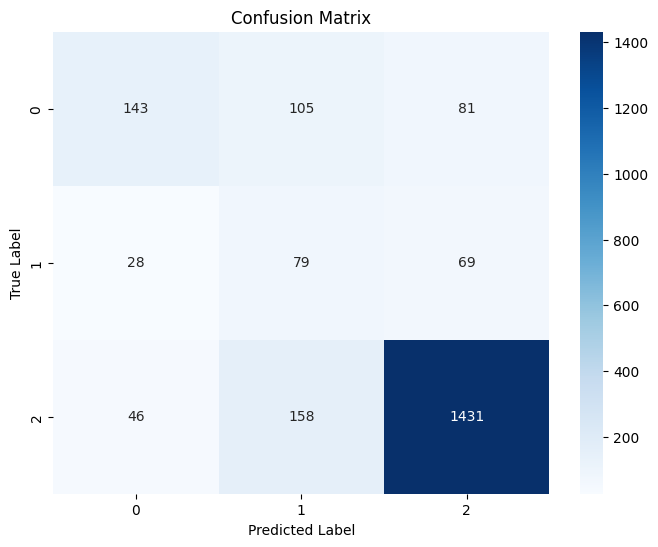

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()